# General FEM Approach 
For a more general description of the finie element method to multiple dimesions, from now on we will introduce cells as subdomains $\Omega^{(e)}$ (previously defined as elements). Their boundaries are denoted as vertices (previously nodes).
We define a set of degrees of freedom - the quantities we actually want to compute.
Every cell $\Omega^{(e)}$ can be splitted up into several nodes, on whose the actual solution will be computed. The indices of the local nodes are distributed onto the global matrix $\mathbf{A}$ via a mapping.


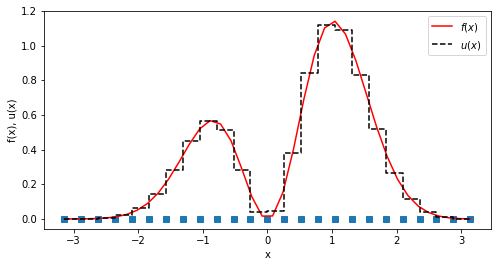

In [13]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

#-------------------------------------------------------
def Uniform_vertices(a, b, N):
    '''Computes uniformly spaced vertices'''
    h = (b-a) / (N-1)
    return [a + i*h for i in range(N)]

#-------------------------------------------------------
def init_mesh(Omega, N, d, **kwargs):
    ''' Function initializes a 2D array which defines N global 
        1D finite elements, with n+1 nodes inside each element
        in the domain Omega = (x0, x1) '''
    # Initialize vertices
    vertices = Uniform_vertices(Omega[0], Omega[1], N+1)
    # Initialize cells
    cells = [[j,j+1] for j in range(N)]
    # Initialize dop_map
    if (d==0):
        dof_map = [[i] for i in range(N)]
    else:
        dof_map = [[i-j%N for i in range(j*(d+1), (j+1)*(d+1))] for j in range(N)]
    
    return (vertices, cells, dof_map)

#-------------------------------------------------------
def Lagrange_polynomial(x, i, points):
    ''' Compute lagrangian interpolation polynomial 
    over domain x at specific points '''
    p = 1
    for k in range(len(points)):
        if k != i:
            p *= (x - points[k]) / (points[i] - points[k])
    return p

#-------------------------------------------------------
def phi_r(r, X, d):
    ''' Defines a Lagrangian basis function for the  
    local node r of an reference element of 
    degree d '''
    nodes = np.linspace(-1., 1., d+1)
    return Lagrange_polynomial(X, r, nodes)


#-------------------------------------------------------
def basis(X, d=1):
    ''' Create all basis functions for a reference 
    element of degree d
    '''
    if (d==0):
        phi = 1.0
    else:
        phi = [phi_r(r, X, d) for r in range(d+1)]
    return phi

#-------------------------------------------------------
def element_matrix(X, phi, Omega_e):
    ''' Creates the element matrix for an element over
    its local domain Omega_e=[x0_e, x1_e] and its 
    basis functions stored in phi 
    '''
    h = Omega_e[1] - Omega_e[0]
    detJ = 0.5*h
    
    if (type(phi)==list):
        
        n = len(phi)
        A_e = np.zeros((n,n))
        for r in range(n):
            for s in range(n):
                A_e[r, s] = np.trapz(phi[r]*phi[s]*detJ, X)
                A_e[s, r] = A_e[r, s]
    else:
        n = 0
        A_e = np.array([[detJ]])
    
    return A_e

#-------------------------------------------------------
def element_rhs(X, f, phi, Omega_e):
    h = Omega_e[1] - Omega_e[0]
    detJ = 0.5*h
    
    if (type(phi)==list):
        n = len(phi)
        b_e = np.zeros(n)
        # Compute mapping from f(x) to f(x(X))
        x_map = np.linspace(Omega_e[0], Omega_e[1], len(X))
        f_map = f(x_map)
        for r in range(n):
            b_e[r] = np.trapz(f_map*phi[r]*detJ, X)
    else:
        x_mean = 0.5*(Omega_e[0]+Omega_e[1])
        b_e = np.array([f(x_mean)*detJ])
    return b_e

#-------------------------------------------------------
def assemble(vertices, cells, dof_map, X, phi, f):
    ''' Function to assemble the global linear system of 
    equations A*x=b for a given mesh which is defined 
    through nodes and elements
    '''
    N_n = len(list(set(np.array(dof_map).ravel())))
    N_e = len(cells)
    A = np.zeros((N_n, N_n))
    b = np.zeros(N_n)
    
    for e in range(N_e):
        Omega_e = (vertices[cells[e][0]], vertices[cells[e][-1]])
        A_e = element_matrix(X, phi, Omega_e)
        b_e = element_rhs(X, f, phi, Omega_e)
        
        for r in range(len(dof_map[e])):
            for s in range(len(dof_map[e])):
                A[dof_map[e][r], dof_map[e][s]] += A_e[r, s]
            b[dof_map[e][r]] += b_e[r]
        
    return (A, b)


def u_glob(vertices, cells, dof_map, C, resolution):
    x_patches = []
    u_patches = []
    for e in range(len(cells)):
        (x_L, x_R) = (vertices[cells[e][0]], vertices[cells[e][-1]])
        d = len(dof_map[e])-1
        X = np.linspace(-1, 1, resolution)
        x = 0.5*(x_L + x_R) + 0.5*(x_R - x_L)*X
        x_patches.append(x)
        
        u_element = np.zeros(resolution)
        for r in range(len(dof_map[e])):
            i = dof_map[e][r] # global node indice
            u_element += C[i] * phi_r(r, X, d)
        u_patches.append(u_element)
    x = np.concatenate(x_patches)
    u = np.concatenate(u_patches)
    return (x, u)


# Test assembly of linear equation system
#-------------------------------------------------------
from numpy import tanh, pi, sin, cos, exp
d = 0
N = 25

Omega = (-pi, pi)
f = lambda x: -tanh(x) * sin(x-pi) * exp(1. - 0.75* (x-0.25)**2)

#Omega = (0, 1)
#f = lambda x: x*(1-x)**8

elem_resolution = 40
x   = np.linspace(Omega[0], Omega[1], elem_resolution)
X   = np.linspace(-1, 1, d+1)
phi = basis(X, d)

# Initialize mesh
(vertices, cells, dof_map)  = init_mesh(Omega, N-1, d)
# Assemble the global linear equation system 
(A, b) = assemble(vertices, cells, dof_map, X, phi, f)
# Solve the global linear equation system
C = np.linalg.solve(A, b)
# Compute the approximation u(x) to f(x)
(x_u, u) = u_glob(vertices, cells, dof_map, C, 40)

# Plot results
#-------------------------------------------------------
element_edges = [vertices[cells[i][0]] for i in range(0,N-1)]
element_edges.append(vertices[-1])

fig = plt.figure()
fig.set_size_inches(8,4)
ax = fig.add_subplot(111)

e_plt = ax.plot(element_edges, [0]*len(element_edges), ls='None', marker='s')

f_plt = ax.plot(x, f(x), c='r', ls='-', label='$f(x)$')
u_plt = ax.plot(x_u, u, c='k', ls='--', label='$u(x)$')
ax.set_xlabel('x') 
ax.set_ylabel('f(x), u(x)')
ax.legend()
plt.show()

# General Finite Element Concept

## The mesh
We are now generalizing the finite element concept. First we need an array with vertices, which will be used to define the boundaries of all cells. These cells (denoted as $\Omega^{(e)}$ together form the domain $\Omega$. The cells themselves can also contain an arbitrary amount of nodes. At these nodes, the approximate function $u(x)$ will be computed in order to minimize its error to the unknown function $f(x)$. The number of unknowns inside the cell is referred to as the degree of freedom. 
The basis functions will be constructed in such a way, that they will be $1$ at these degrees of freedom and $0$ at all others.
This will ensure, when $u(x) = \sum_{j} c_j \phi_j$ for a degree of freedom $i$ we will get $u = c_i$ (so we do not need to care about the values of $\phi_j$ at these points - $\phi$ is  nondimensional so to say).

So first we will need a function to create the "mesh", as we will now call all cells and vertices. 

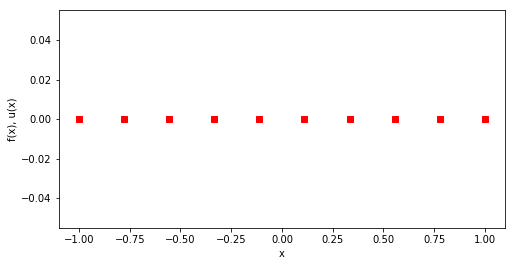

In [40]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

#-------------------------------------------------------
def Uniform_vertices(a, b, N):
    '''Computes uniformly spaced vertices'''
    h = (b-a) / (N-1)
    return [a + i*h for i in range(N)]

#-------------------------------------------------------
def init_mesh(Omega, N, d, **kwargs):
    ''' Function initializes a 2D array which defines N global 
        1D finite elements, with n+1 nodes inside each element
        in the domain Omega = (x0, x1) '''
    # Initialize vertices
    vertices = Uniform_vertices(Omega[0], Omega[1], N+1)
    # Initialize cells
    cells = [[j,j+1] for j in range(N)]
    # Initialize dop_map
    if (d==0):
        dof_map = [[i] for i in range(N)]
    else:
        dof_map = [[i-j%N for i in range(j*(d+1), (j+1)*(d+1))] for j in range(N)]
    
    return (vertices, cells, dof_map)










#-------------------------------------------------------
# Set the domain boundaries, the number of nodes and the 
# degree of freedom for the cells
Omega = (-1, 1)
N = 10
d = 2

# Initialize mesh
(vertices, cells, dof_map)  = init_mesh(Omega, N-1, d)

element_edges = [vertices[cells[i][0]] for i in range(0,N-1)]
element_edges.append(vertices[-1])

# Plot the mesh
fig = plt.figure()
fig.set_size_inches(8,4)
ax = fig.add_subplot(111)

e_plt = ax.plot(element_edges, [0]*len(element_edges), ls='None', marker='s', c='r')
ax.set_xlabel('x') 
ax.set_ylabel('f(x), u(x)')
plt.show()

## The Basis Functions
Next we will introduce the basis functions $\phi_j$.
They hold the important property 
$$
\phi_i(x_j)= \delta_{ij}, \quad \delta_{ij} = \begin{cases}
1, \quad i=j, \\
0, \quad i\neq j
\end{cases}
$$
whereby $x_j$ is a degree of freedom node inside a cell, that has the global node number $j$.
Lagrangian polynomials, hold this property, which are defined as:
$$
\phi_i(x) = \prod_{j=0, j\neq i}^N \frac{x-x_j}{x_i-x_j}, \qquad i=0,...,N
$$

Lets create a new mesh with less cells. This time we will also plot the degrees of freedom inside the elements (denoted by littles black x's). 
We also plot the basis functions over a specific cell.

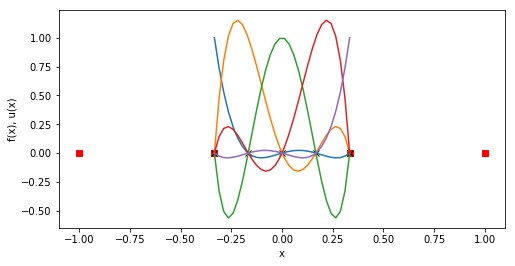

In [80]:
#-------------------------------------------------------
def Lagrange_polynomial(x, i, points):
    ''' Compute lagrangian interpolation polynomial 
    over domain x at specific points '''
    p = 1
    for k in range(len(points)):
        if k != i:
            p *= (x - points[k]) / (points[i] - points[k])
    return p

#-------------------------------------------------------
def phi_i(i, X, d):
    ''' Defines a Lagrangian basis function for the  
    local node i of an reference element of 
    degree d '''
    nodes = np.linspace(-1., 1., d+1)
    return Lagrange_polynomial(X, i, nodes)


#-------------------------------------------------------
def basis(X, d=1):
    ''' Create all basis functions for a reference 
    element of degree d
    '''
    if (d==0):
        phi = 1.0
    else:
        phi = [phi_r(r, X, d) for r in range(d+1)]
    return phi








#-------------------------------------------------------
# Set the domain boundaries, the number of nodes and the 
# degree of freedom for the cells
Omega = (-1, 1)
N = 4
d = 4

# Initialize the basis functions
resolution = 30
X   = np.linspace(-1, 1, resolution)
phi = basis(X, d)

# Initialize mesh
(vertices, cells, dof_map)  = init_mesh(Omega, N-1, d)
element_edges = [vertices[cells[i][0]] for i in range(0,N-1)]
element_edges.append(vertices[-1])

# Do some special stuff, if d==0 
iCell = int((N-1)/2)
nodes = np.linspace(vertices[cells[iCell][0]], vertices[cells[iCell][1]], d+1) 
if d == 0:
    nodes = [vertices[cells[iCell][0]], vertices[cells[iCell][1]]]

# Plot the mesh and the basis functions
fig = plt.figure()
fig.set_size_inches(8,4)
ax = fig.add_subplot(111)

# Plot cell boundaries
e_plt = ax.plot(element_edges, [0]*len(element_edges), ls='None', marker='s', c='r')

# Plot nodes and basis functions
n_plot   = ax.plot(nodes, [0]*len(nodes), ls='None', marker='x', c='k')
for i in range(0, d+1):
    if type(phi)==list:
        ax.plot(np.linspace(nodes[0], nodes[-1], resolution), phi[i], ls='-')
    else:
        # Again, do special stuff, if d==0 
        ax.plot(np.linspace(nodes[0], nodes[-1], resolution), [phi]*resolution, ls='-')


ax.set_xlabel('x') 
ax.set_ylabel('f(x), u(x)')
plt.show()

In [55]:
nodes

[array([-1.        , -0.83333333, -0.66666667, -0.5       , -0.33333333]),
 array([-3.33333333e-01, -1.66666667e-01, -5.55111512e-17,  1.66666667e-01,
         3.33333333e-01]),
 array([0.33333333, 0.5       , 0.66666667, 0.83333333, 1.        ])]